## MANormalizingFlows example use

This jupyter notebook guides you through a simple example of using the classes provided in MANormalizingFlows for two-dimensional density estimation of a simple distribution.

### Non-conditional density estimation

We begin by importing the necessary libraries:

In [1]:
import MANormalizingFlows as manf
import numpy as np
import matplotlib.pyplot as plt

The following cell is a (somewhat unsafe) workaround for a kernel crashing problem sometimes encountered when installing tensorflow and matplotlib through conda. Only relevant if you encounter this problem.

In [2]:
import os
os.environ["KMP_DUPLICATE_LIB_OK"]="TRUE"

The following function creates our dataset (a randomised parable):

In [3]:
def make_moon(n_samples, x_dim, y_dim):
    y = np.random.random(n_samples)
    epsilon = np.random.normal(0, 0.03, n_samples)
    x = (x_dim[1]-x_dim[0]) * ((y - 0.5)**2 + epsilon) + x_dim[0]
    y = (y_dim[1] - y_dim[0]) * y + y_dim[0]
    return np.c_[x,y]

As training data we use 100,000 samples:

In [4]:
moon = make_moon(100000, [0,1], [0,1])

Now we define the normalizing flow (only the first two arguments are mandatory, in_shape is determined by the dimension of our dataset):

In [5]:
flow = manf.MAFlowModel(n_coupling=5, in_shape=2, num_hidden_layers=1, num_nodes=128)

Next, we compile and train the model in typical tensorflow-fashion:

In [6]:
flow.compile(optimizer="Adam")
history = flow.fit(moon, batch_size=128, epochs=100)

Epoch 1/100
782/782 [==============================] - 5s 3ms/step - loss: -1.7705 - logprob: 2.7451 - logdet: -4.5156
Epoch 2/100
782/782 [==============================] - 2s 3ms/step - loss: -2.0025 - logprob: 2.8209 - logdet: -4.8234
Epoch 3/100
782/782 [==============================] - 2s 3ms/step - loss: -2.0170 - logprob: 2.8277 - logdet: -4.8447
Epoch 4/100
782/782 [==============================] - 3s 4ms/step - loss: -2.0239 - logprob: 2.8303 - logdet: -4.8542
Epoch 5/100
782/782 [==============================] - 3s 4ms/step - loss: -2.0287 - logprob: 2.8313 - logdet: -4.8600
Epoch 6/100
782/782 [==============================] - 4s 5ms/step - loss: -2.0304 - logprob: 2.8337 - logdet: -4.8641
Epoch 7/100
782/782 [==============================] - 4s 5ms/step - loss: -2.0348 - logprob: 2.8322 - logdet: -4.8670
Epoch 8/100
782/782 [==============================] - 3s 4ms/step - loss: -2.0360 - logprob: 2.8332 - logdet: -4.8692
Epoch 9/100
782/782 [===========================

Let's take a look at the training loss to confirm the model has converged:

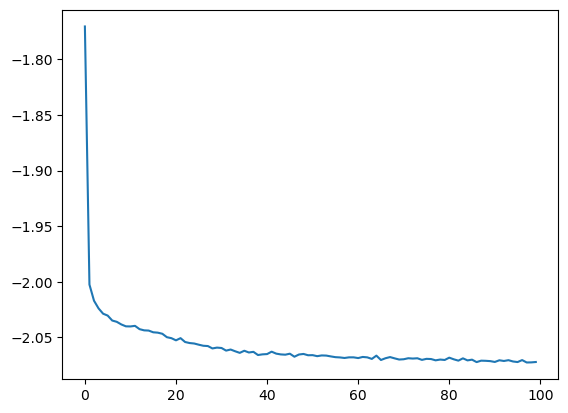

In [7]:
plt.plot(history.history["loss"])

With the trained model we can sample 1000 points and compare their distribution to the original one:

32/32 [==============================] - 0s 2ms/step


Text(0.5, 1.0, 'Normalizing Flow')

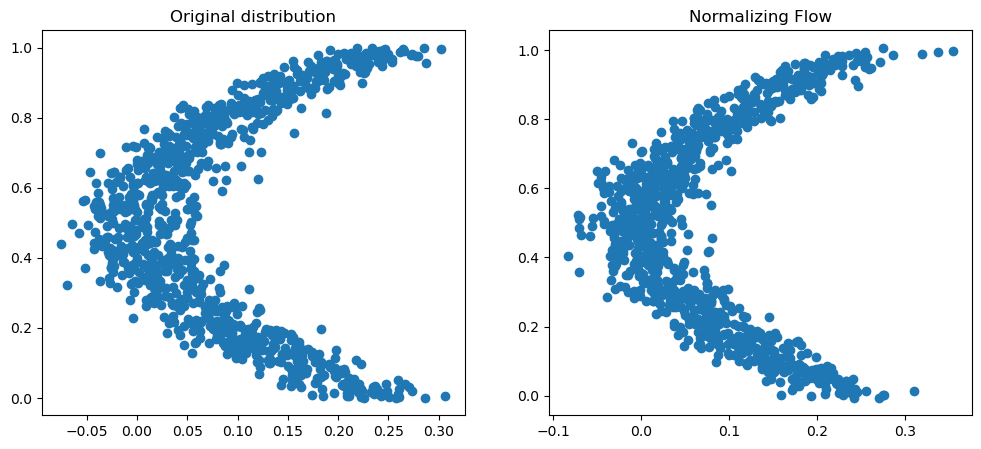

In [18]:
sample = flow.sample(1000)
fig, ax = plt.subplots(1, 2, figsize=(12, 5))
ax[0].scatter(moon[:1000,0], moon[:1000,1])
ax[0].set_title("Original distribution")
ax[1].scatter(sample[:,0], sample[:,1])
ax[1].set_title("Normalizing Flow")

As we can see, the shape of the original distribution is nicely replicated!

### Conditional density estimation

This time the moon shape from earlier depends on a conditional parameter which be assume to be evenly distributed between 0 and 1:

In [26]:
def make_cond_moon(n_samples, x_dim, y_dim, c=None):
    if c is not None:
        c = c * np.ones(n_samples)
    else:
        c = np.random.random(n_samples)
    y = np.random.random(n_samples)
    epsilon = np.random.normal(0, 0.03, n_samples)
    x = (x_dim[1]-x_dim[0]) * c * ((y - 0.5)**2 + epsilon) + x_dim[0]
    y = (y_dim[1] - y_dim[0]) * y + y_dim[0]
    return np.c_[c,x,y]

One can think of this as a three-dimensional distribution, but the normalizing flow is only supposed to learn the distributions in two of the dimensions. Again, we generate a dataset of 100,000 samples:

In [21]:
cond_moon = make_cond_moon(100000, [0,1], [0,1])

For the conditional model, we need a histogram of the distribution of the conditional parameter, so let's make that:

In [22]:
cond_hist = np.histogram(cond_moon[:,0])

Now we can define the conditional flow model and train it:

In [23]:
cond_flow = manf.MAConditionalFlowModel(n_coupling=5, in_shape=2, param_hists=[cond_hist], num_hidden_layers=1, num_nodes=128)
cond_flow.compile(optimizer="Adam")
cond_history = cond_flow.fit(cond_moon, batch_size=128, epochs=100)

Epoch 1/100
782/782 [==============================] - 7s 5ms/step - loss: -2.0837 - logprob: 2.5528 - logdet: -4.6365
Epoch 2/100
782/782 [==============================] - 4s 5ms/step - loss: -2.5484 - logprob: 2.7516 - logdet: -5.3000
Epoch 3/100
782/782 [==============================] - 5s 6ms/step - loss: -2.5851 - logprob: 2.8152 - logdet: -5.4004
Epoch 4/100
782/782 [==============================] - 5s 6ms/step - loss: -2.5959 - logprob: 2.8331 - logdet: -5.4290
Epoch 5/100
782/782 [==============================] - 5s 6ms/step - loss: -2.6029 - logprob: 2.8394 - logdet: -5.4422
Epoch 6/100
782/782 [==============================] - 5s 6ms/step - loss: -2.6082 - logprob: 2.8397 - logdet: -5.4478
Epoch 7/100
782/782 [==============================] - 5s 6ms/step - loss: -2.6101 - logprob: 2.8426 - logdet: -5.4528
Epoch 8/100
782/782 [==============================] - 5s 6ms/step - loss: -2.6126 - logprob: 2.8431 - logdet: -5.4557
Epoch 9/100
782/782 [===========================

Again, let's check the history:

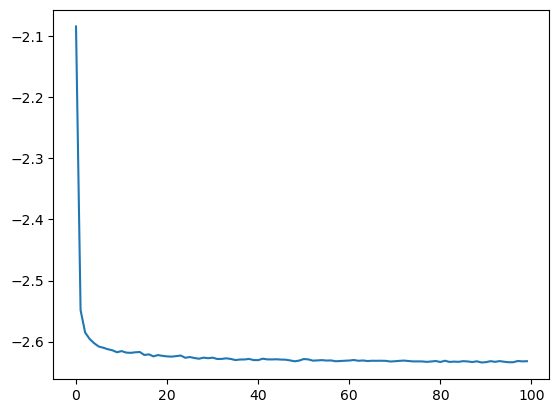

In [25]:
plt.plot(cond_history.history["loss"])

Now we can compare the distributions for different values of the conditional parameter to see if they fit:

32/32 [==============================] - 0s 2ms/step


(-0.05, 1.05)

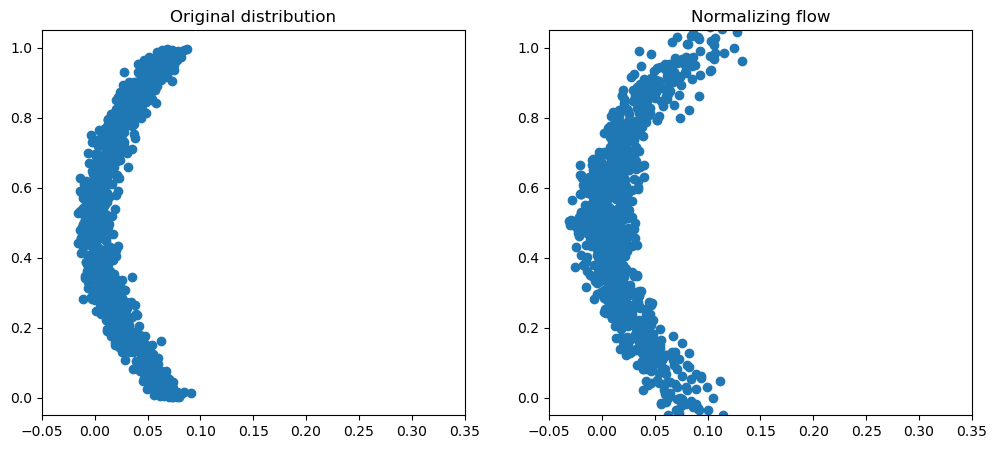

In [39]:
C = 0.3 # conditional parameter

test_cond_moon = make_cond_moon(1000, [0,1], [0,1], C)
cond_sample = cond_flow.sample(1000, C * np.ones((1000,1)))

fig, ax = plt.subplots(1, 2, figsize=(12, 5))
ax[0].scatter(test_cond_moon[:,1], test_cond_moon[:,2])
ax[0].set_title("Original distribution")
ax[0].set_xlim((-0.05, 0.35))
ax[0].set_ylim((-0.05, 1.05))
ax[1].scatter(cond_sample[:,1], cond_sample[:,2])
ax[1].set_title("Normalizing flow")
ax[1].set_xlim((-0.05, 0.35))
ax[1].set_ylim((-0.05, 1.05))

Again, a nice match!